# Introduction
Baseline model comparisons on the miniature dataset
4 models are compared here: 
1. VGG-16
2. ResNet-50
3. MobileNet
4. DenseNet-169

<a id = "1"></a><br>
# Importing Necessary Libraries

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import InputLayer, BatchNormalization,Activation, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet169 
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.applications.xception import Xception

import tqdm
import keras
import glob
import cv2
import warnings
warnings.filterwarnings("ignore")

import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)



/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/30.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/29.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/28.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/32 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/31.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/32.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/30 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/Moderate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Num GPUs Available:  1


<a id = "2"></a><br>
# Loading Data and Data Preprocessing

In [2]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     
train_data = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=img_size, 
                                                 subset="training",
                                                 class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_data= image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=True,
                                                 target_size=img_size,
                                                 class_mode='categorical')


submission = image_generator.flow_from_directory(
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                subset="validation",
                                                 target_size=img_size, 
                                                 class_mode=None)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


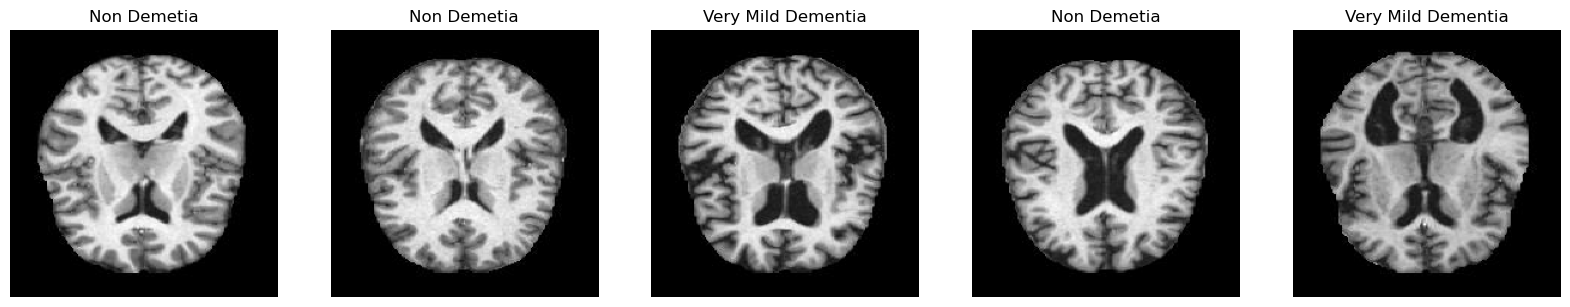

In [3]:
#Visualize some example with labels
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in range(5):
    rand1 = np.random.randint(len(train_data))
    rand2 = np.random.randint(60)
    ax[i].imshow(train_data[rand1][0][rand2])
    ax[i].axis('off')
    a = train_data[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')
        
     

In [4]:
#same for every model
batch_size=60
epoch=35
callback= keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

<a id = "4"></a><br>
# VGG16

In [8]:
vgg16 = VGG16(input_shape=(224, 224, 3), weights="imagenet", include_top=False)


for layer in vgg16.layers:
    layer.trainable = False


x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelvgg16 = Model(inputs=vgg16.input, outputs=out)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

#compiling
modelvgg16.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Summary
modelvgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
hist_vgg16=modelvgg16.fit(train_data, epochs=epoch, validation_data=validation_data, callbacks=callback)

Epoch 1/35
86/86 [==============================] - 57s 534ms/step - loss: 275.6641 - accuracy: 0.5376 - val_loss: 12.5284 - val_accuracy: 0.3503
Epoch 2/35
86/86 [==============================] - 18s 206ms/step - loss: 1040.2501 - accuracy: 0.5145 - val_loss: 3.1362 - val_accuracy: 0.5770
Epoch 3/35
86/86 [==============================] - 18s 214ms/step - loss: 257.2929 - accuracy: 0.6794 - val_loss: 3.0197 - val_accuracy: 0.6380
Epoch 4/35
86/86 [==============================] - 18s 207ms/step - loss: 717.1629 - accuracy: 0.7108 - val_loss: 2.9501 - val_accuracy: 0.5786
Epoch 5/35
86/86 [==============================] - 18s 208ms/step - loss: 901.3312 - accuracy: 0.7247 - val_loss: 2.7582 - val_accuracy: 0.6317
Epoch 6/35
86/86 [==============================] - 17s 202ms/step - loss: 60.7137 - accuracy: 0.7635 - val_loss: 2.2850 - val_accuracy: 0.6661
Epoch 7/35
86/86 [==============================] - 18s 209ms/step - loss: 772.7584 - accuracy: 0.8127 - val_loss: 2.0988 - val_a

<a id = "5"></a><br>
## VGG16 Evaluation

In [10]:
loss_vgg16,accuracy_vgg16 = modelvgg16.evaluate(validation_data)


22/22 [==============================] - 4s 157ms/step - loss: 1.6522 - accuracy: 0.7052


<a id = "8"></a><br>
# ResNet50

In [14]:
rn50 = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn50.layers:
    layer.trainable = False
x = Flatten()(rn50.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelrn50= Model(inputs=rn50.input, outputs=out)

#compiling
modelrn50.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
#Summary
modelrn50.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [15]:
hist_rn50=modelrn50.fit(train_data, epochs=epoch, validation_data=validation_data, callbacks=callback)

Epoch 1/35
86/86 [==============================] - 22s 207ms/step - loss: 2.1011 - accuracy: 0.4497 - val_loss: 1.0121 - val_accuracy: 0.5020
Epoch 2/35
86/86 [==============================] - 17s 199ms/step - loss: 0.9923 - accuracy: 0.5063 - val_loss: 1.0320 - val_accuracy: 0.5012
Epoch 3/35
86/86 [==============================] - 19s 221ms/step - loss: 0.9679 - accuracy: 0.5188 - val_loss: 1.0229 - val_accuracy: 0.5020
Epoch 4/35
86/86 [==============================] - 18s 204ms/step - loss: 0.9484 - accuracy: 0.5229 - val_loss: 1.0150 - val_accuracy: 0.5027
Epoch 5/35
86/86 [==============================] - 19s 222ms/step - loss: 0.9297 - accuracy: 0.5274 - val_loss: 0.9998 - val_accuracy: 0.5137
Epoch 6/35
86/86 [==============================] - 19s 219ms/step - loss: 0.9128 - accuracy: 0.5300 - val_loss: 0.9775 - val_accuracy: 0.5082
Epoch 7/35
86/86 [==============================] - 18s 211ms/step - loss: 0.9063 - accuracy: 0.5370 - val_loss: 0.9786 - val_accuracy: 0.5082

<a id = "9"></a><br>
## ResNet50 Evaluation

In [16]:
loss_rn50,accuracy_rn50= modelrn50.evaluate(validation_data)

22/22 [==============================] - 4s 155ms/step - loss: 0.9255 - accuracy: 0.5762


<a id = "12"></a><br>
# MobileNet

In [19]:
mobilenet = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in mobilenet.layers:
    layer.trainable = False
x = Flatten()(mobilenet.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelmnet= Model(inputs=mobilenet.input, outputs=out)

#Compiling
modelmnet.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
#Summary
modelmnet.summary()


17225924/17225924 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128  

In [20]:
hist_mnet=modelmnet.fit(train_data, epochs=epoch, validation_data=validation_data, callbacks=callback)

Epoch 1/35
86/86 [==============================] - 19s 197ms/step - loss: 2.9837 - accuracy: 0.6380 - val_loss: 1.4295 - val_accuracy: 0.6216
Epoch 2/35
86/86 [==============================] - 18s 205ms/step - loss: 0.3112 - accuracy: 0.8760 - val_loss: 1.2037 - val_accuracy: 0.6341
Epoch 3/35
86/86 [==============================] - 15s 172ms/step - loss: 0.1296 - accuracy: 0.9711 - val_loss: 1.1165 - val_accuracy: 0.6638
Epoch 4/35
86/86 [==============================] - 16s 187ms/step - loss: 0.0656 - accuracy: 0.9936 - val_loss: 1.0665 - val_accuracy: 0.6818
Epoch 5/35
86/86 [==============================] - 15s 172ms/step - loss: 0.0394 - accuracy: 0.9984 - val_loss: 1.1485 - val_accuracy: 0.6826
Epoch 6/35
86/86 [==============================] - 15s 171ms/step - loss: 0.0237 - accuracy: 0.9996 - val_loss: 1.3040 - val_accuracy: 0.6622
Epoch 7/35
86/86 [==============================] - 16s 185ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 1.1381 - val_accuracy: 0.6912

<a id = "13"></a><br>
## MobileNet Evaluation

In [21]:
loss_mnet,accuracy_mnet= modelmnet.evaluate(validation_data)

22/22 [==============================] - 3s 127ms/step - loss: 1.0665 - accuracy: 0.6818


<a id = "16"></a><br>
# DenseNet169

In [22]:
dnet169 = DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in dnet169.layers:
    layer.trainable = False
x = Flatten()(dnet169.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modeldnet169= Model(inputs=dnet169.input, outputs=out)

# Compiling
modeldnet169.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Summary
modeldnet169.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_9[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [23]:
hist_dnet169=modeldnet169.fit(train_data, epochs=epoch, validation_data=validation_data, callbacks=callback)

Epoch 1/35
86/86 [==============================] - 37s 293ms/step - loss: 4.1365 - accuracy: 0.5895 - val_loss: 1.9715 - val_accuracy: 0.5825
Epoch 2/35
86/86 [==============================] - 17s 202ms/step - loss: 0.7622 - accuracy: 0.7586 - val_loss: 1.5726 - val_accuracy: 0.6013
Epoch 3/35
86/86 [==============================] - 18s 207ms/step - loss: 0.5517 - accuracy: 0.8260 - val_loss: 1.8204 - val_accuracy: 0.5966
Epoch 4/35
86/86 [==============================] - 18s 204ms/step - loss: 0.2147 - accuracy: 0.9199 - val_loss: 1.8950 - val_accuracy: 0.6192
Epoch 5/35
86/86 [==============================] - 17s 196ms/step - loss: 0.2622 - accuracy: 0.9117 - val_loss: 1.7031 - val_accuracy: 0.6294
Epoch 6/35
86/86 [==============================] - 17s 194ms/step - loss: 0.0667 - accuracy: 0.9781 - val_loss: 1.8051 - val_accuracy: 0.6161
Epoch 7/35
86/86 [==============================] - 18s 209ms/step - loss: 0.4384 - accuracy: 0.8998 - val_loss: 2.8104 - val_accuracy: 0.6349

<a id = "17"></a><br>
## DenseNet169 Evaluation

In [24]:
loss_dnet169,accuracy_dnet169= modeldnet169.evaluate(validation_data)


22/22 [==============================] - 4s 158ms/step - loss: 1.5726 - accuracy: 0.6013


<a id = "22"></a><br>
# Model Comparison

         Model      Loss  Accuracy
1     ResNet50  0.925478  0.576231
3  DenseNet169  1.572567  0.601251
2    MobileNet  1.066501  0.681783
0        VGG16  1.652156  0.705238


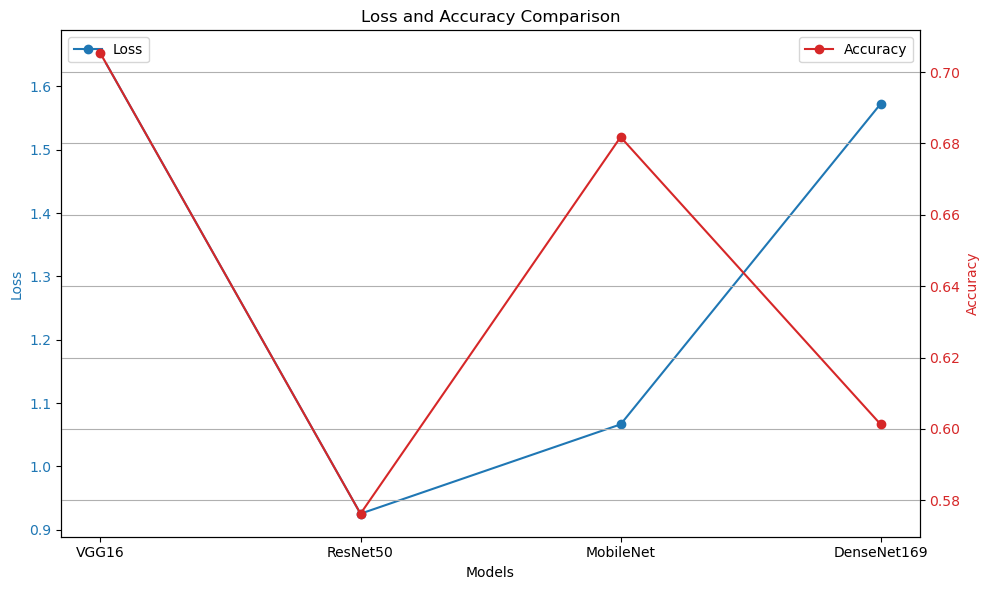

In [25]:
models = ['VGG16', 'ResNet50','MobileNet', 'DenseNet169']
loss_values = [loss_vgg16,loss_rn50,loss_mnet,loss_dnet169]
accuracy_values = [accuracy_vgg16, accuracy_rn50, accuracy_mnet, accuracy_dnet169]

data = {'Model': models, 'Loss': loss_values, 'Accuracy': accuracy_values}
df = pd.DataFrame(data)
df = df.sort_values(by='Accuracy')#ranked by accuracy1
print(df)


fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Models')
ax1.set_ylabel('Loss', color=color)
ax1.plot(models, loss_values, marker='o', color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')


ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(models, accuracy_values, marker='o', color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Loss and Accuracy Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()